In [1]:
#tweetlerin veritabanından alınması
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import zemberek
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
durakwords= set(stopwords.words("turkish"))
import string
import re
import zemberek
import jpype,os
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
from scipy import stats
import seaborn as sns
from collections import Counter
from keras.models import Sequential
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
df=pd.DataFrame()
df=pd.read_csv("C:/Users/user/tweets/tweets2.csv")



In [2]:
#Zemberek kütüphanesinin kullanılabilmesi için Jpype ile JVM oluşturulması
ZEMBEREK_PATH = r'C:\Users\user\Desktop\dersler\tweets\zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
#Morphology kütüphanesini kullanacağımızdan burada oluşturuyoruz
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()


In [3]:
#Tweetlerin küçük harfe dönüştürülmesi
df= df.rename(columns = {'hash,content,class': 'tweets'})
df['tweets']=df['tweets'].str.lower()

In [4]:
#tweetlerin son değerlerine göre yeni bir dataframe e yerleştirilmesi
#1 tek,2 spor,eko,pol,mag,sağ,kült
#df[df.tweets.str.endswith('2')]
df['icerik']='icerik'
df['cleantext']='cleantext'
df.loc[df['tweets'].str.endswith('1'),'icerik']="teknoloji"
df.loc[df['tweets'].str.endswith('2'),'icerik']="spor"
df.loc[df['tweets'].str.endswith('3'),'icerik']="ekonomi"
df.loc[df['tweets'].str.endswith('4'),'icerik']="politika"
df.loc[df['tweets'].str.endswith('5'),'icerik']="magazin"
df.loc[df['tweets'].str.endswith('8'),'icerik']="kultur"
df.loc[df['tweets'].str.endswith('7'),'icerik']="saglik"
df.loc[df['tweets'].str.endswith('1'),'label']="1"
df.loc[df['tweets'].str.endswith('2'),'label']="2"
df.loc[df['tweets'].str.endswith('3'),'label']="3"
df.loc[df['tweets'].str.endswith('4'),'label']="4"
df.loc[df['tweets'].str.endswith('5'),'label']="5"
df.loc[df['tweets'].str.endswith('8'),'label']="8"
df.loc[df['tweets'].str.endswith('7'),'label']="7"
pd.to_numeric(df.label)

0        2
1        8
2        4
3        2
4        5
        ..
34995    1
34996    1
34997    1
34998    1
34999    1
Name: label, Length: 35000, dtype: int64

In [5]:
def mentionRemove(text):
    text = re.sub(r'@\w+', '', text)#mentionların çıkartırılması
    return text

In [6]:
def siteRemove(text):
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)#bağlantıların çıkarılması
    return text

In [7]:
def puncRemove(text):
    text = re.sub('[^a-zığüşiöç\s]', '', text)#özel karakterlerin ve sayıların çıkarılması
    text = re.sub(r"Â", "A", text)#umlautlu karakterlerinn değiştirilmesi
    text = re.sub(r"â", "a", text)
    text = re.sub(r"Î", "I", text)
    text = re.sub(r"î", "ı", text)
    text = re.sub(r"Û", "U", text)
    text = re.sub(r"û", "u", text)

    return text

In [8]:
def removeSw(text):
    text=[w for w in tweet if w.lower() not in durakwords]#stopwordlerin çıkarılması
    return text

In [9]:
def rootFinder(text):
    pos=[]
    textlist=text.split(" ")
    analysis: java.util.ArrayList = ( morphology.analyzeAndDisambiguate(text).bestAnalysis() )
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}' 
        if (str(analysis.getLemmas()[0]) == "UNK"):
            pos.append(textlist[i-1])
        else:     
            pos.append(f'{str(analysis.getLemmas()[0])}')
    return pos


In [10]:
def emojiRemove(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [11]:
#hash kısmının ve sondaki içerik belirteci ve tweet bağlantısının kaldırılması
#utf-16 karakterlerin elenmesi
#kelimelerin ayrıştırılması
#tweet içerisindeki bağlantıların çıkarılması
#tweet içindeki mentionların çıkarılması
p=set(string.punctuation)

def cleaner(text):
    text=text
    text=mentionRemove(text)#mentionların çıkartırılması
    text=siteRemove(text)#bağlantıların çıkarılması
    text=puncRemove(text)#özel karakterlerin ve sayıların çıkarılması
    text=emojiRemove(text)
    text=rootFinder(text)#kelime köklerinin bulunması
    text=removeSw(text)#durak kelimelerin elenmesi
    return text
for x in range(0,len(df)):
    #tweet="ve ya da için baba veya"
    tweet=df.iloc[x,0]
    tweet=mentionRemove(tweet)#mentionların çıkartırılması
    tweet=siteRemove(tweet)#bağlantıların çıkarılması
    #tweet.replace("aracılığıyla","a")
    tweet=puncRemove(tweet)#özel karakterlerin ve sayıların çıkarılması
    tweet=rootFinder(tweet)#kelime köklerinin bulunması
    tweet=removeSw(tweet)#durak kelimelerin elenmesi
    tweet=' '.join(tweet)
    #tweet=cleaner(tweet)
    df.iloc[x,2]=tweet
    pos=[]



In [12]:
###KNN algorithm for k=27
df

,tweets,icerik,cleantext,label
0,"-9223050356879576544,son daki̇ka | futbol fede...",spor,son dakika futbol federasyon tahkim kurul beşi...,2
1,"-9222573041315337832,esen karol atölyesi’nin a...",kultur,esen karol atölye ardından,8
2,"-9222496288495997909,üniversiteler odtü´ye cep...",politika,üniversite odtü cephe al aracılığıyla,4
3,"-9222480792388698410,beşi̇ktaş'ın yeni yapılac...",spor,beşiktaş yeni yap stat ilgi detay sabah spor f...,2
4,"-9222466474619073376,cem yılmaz yeni filminin ...",magazin,cem yıl yeni film başrol ver,5
...,...,...,...,...
34995,"9210072101385251033,lg pro g2'nin bazı özellik...",teknoloji,lg pro g özellik sız,1
34996,"9212178017043882510,bu marka, twitter ve faceb...",teknoloji,marka twitter facebook sol sıfır bırak,1
34997,"9214331797304618382,turkcell müşterileri 4g'yi...",teknoloji,turkcell müşteri g deneme başla,1
34998,"9216183026900103052,facebook kullanan çocuklar...",teknoloji,facebook kullan çocuk mutsuz,1


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import gc
from sklearn.metrics import classification_report, confusion_matrix
texts=df.cleantext
label=df.icerik
train_text, test_text, train_label, test_label = train_test_split(texts,label,test_size=0.3,random_state=44)
# vectorizing data
vectorizer = TfidfVectorizer()
train_text = vectorizer.fit_transform(train_text)
test_text = vectorizer.transform(test_text)
# training
classifier = KNeighborsClassifier(n_neighbors=27, weights='distance', algorithm='brute',
                                  metric='euclidean')
classifier.fit(train_text, train_label)
# fitting
predicted_labels = classifier.predict(test_text)


In [18]:
# finding Accuracy
print("the accuracy score is ",accuracy_score(test_label,predicted_labels))

the accuracy score is  0.7659047619047619


In [14]:
classifier.predict(vectorizer.transform(["aşı hekim"]))

array(['saglik'], dtype=object)

In [15]:
print(classification_report(test_label, predicted_labels,target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))

              precision    recall  f1-score   support

     ekonomi       0.75      0.73      0.74      1501
      kultur       0.76      0.72      0.74      1556
     magazin       0.63      0.78      0.70      1463
    politika       0.78      0.73      0.75      1484
      saglik       0.80      0.82      0.81      1505
        spor       0.86      0.81      0.84      1463
   teknoloji       0.83      0.77      0.80      1528

    accuracy                           0.77     10500
   macro avg       0.77      0.77      0.77     10500
weighted avg       0.77      0.77      0.77     10500



2021-01-25 18:23:13,253 - numexpr.utils - INFO
Msg: NumExpr defaulting to 8 threads.



Text(0.5, 1.0, 'CONFUSION MATRIX\n')

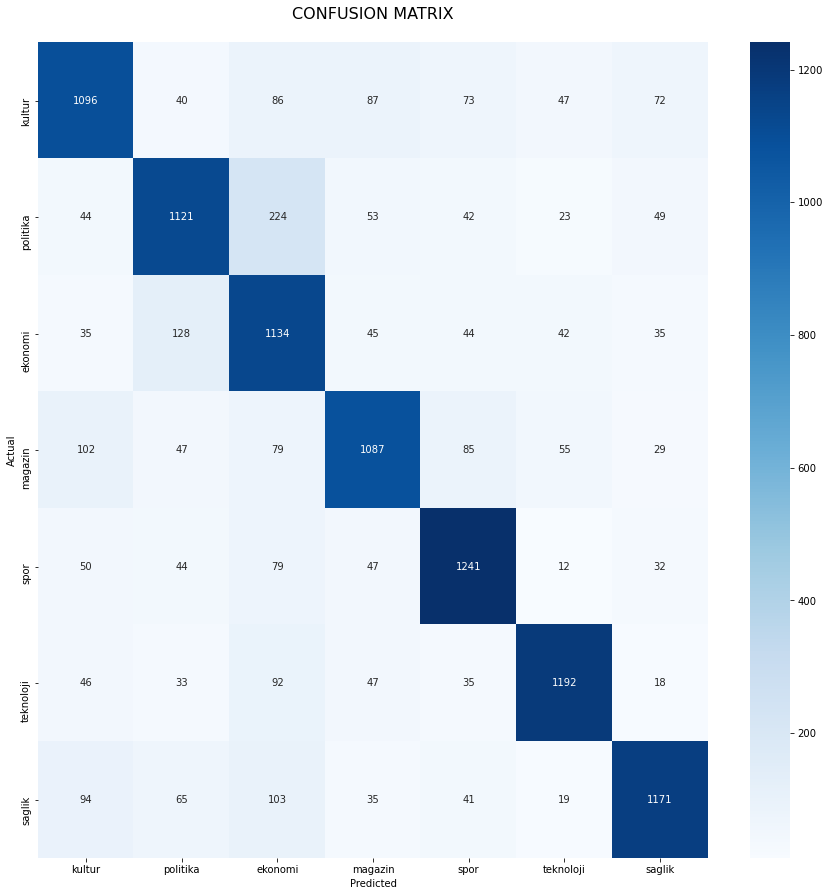

In [16]:
conf_mat = confusion_matrix(test_label, predicted_labels)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16)